In [1]:
from __future__ import division, print_function
%matplotlib inline

In [2]:
from future.builtins import next

In [3]:
import numpy as np

In [4]:
import h5py

In [5]:
import qinfer as qi
import qutip as qt

In [6]:
import itertools as it
from functools import partial

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [8]:
def quantile_range(lower=0.25, upper=0.75):
    def reduction(data, axis):
        return tuple([
            np.percentile(data, axis=axis, q=100 * q)
            for q in (lower, upper)
        ])
    return reduction

## Performance Testing and Measurement Definitions ##

In [9]:
fiducial_state = qt.tensor([
    qt.Qobj(np.diag([0.9, 0.1]))
] * 2)
fiducial_state.dims = [[4], [4]]
fiducial_state

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.81  0.    0.    0.  ]
 [ 0.    0.09  0.    0.  ]
 [ 0.    0.    0.09  0.  ]
 [ 0.    0.    0.    0.01]]

In [10]:
basis = qi.tomography.pauli_basis(2)
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))
fid_prior = qi.tomography.GinibreDistribution(basis, rank=2)
# prior = qi.tomography.GADFLIDistribution(
#     fid_prior,
#     mean=fiducial_state
# )
prior = fid_prior

In [11]:
true_state = qt.tensor([qt.ket2dm(qt.basis(2, 0))] * 2)
true_mps = basis.state_to_modelparams(true_state)[np.newaxis, :]

In [12]:
fiducial_measurement = qt.ket2dm(qt.tensor([qt.basis(2, 0)] * 2))
fiducial_measurement

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

In [13]:
def PreRotationMeasurements(single_qubit_ops, core_measurement, n_qubits=2, include_conjugate=True):
    """Generate a set of measurement operators based on a set of rotations of a core measurement,
    optionally including the conjugate of the same measurements as well.  Easily generates the sets in
    http://journals.aps.org/pra/pdf/10.1103/PhysRevA.81.062325 using [I, PiX, PiX2, PiY2], M = |00><00|,
    include_conjugate=True"""

    assert (n_qubits == 2) #May optionally generalize later

    FullMeasurementList = []
    
    for m1 in single_qubit_ops:
        for m2 in single_qubit_ops:
            FullMeasurementList.append(np.dot(np.conj(np.kron(m1, m2).T), np.dot(core_measurement, np.kron(m1, m2))))

    if (include_conjugate):
        FullMeasurementList.extend([np.conj(m) for m in FullMeasurementList])

    return FullMeasurementList

#Define Tomographic Measurements
Id = np.eye(2, dtype=complex)
X = np.array([[0.0, 1.0],
              [1.0, 0.0]])
Y = np.array([[0.0, -1.0j],
              [1.0j, 0.0]])
Z = np.array([[1.0, 0.0],
              [0.0, -1.0]])

PiX = np.cos(np.pi/2.) * Id - 1.j * np.sin(np.pi/2.) * X
PiX2 = np.cos(np.pi/4.) * Id - 1.j * np.sin(np.pi/4.) * X
PiY2 = np.cos(np.pi/4.) * Id - 1.j * np.sin(np.pi/4.) * Y

# beta_vec=[0.32182797213542436,0.20388382857043799,0.26690981910827039,0.17047277839951108]
beta_vec=[0.25,.25,.25,.25]
CoreMeasurement = (np.kron(Id, Id) + np.kron(Z, Id) + np.kron(Id,Z) + np.kron(Z,Z))

CoreMeasurement=np.multiply(CoreMeasurement,beta_vec)

SingleMeasurementList = [Id, PiX, PiX2, PiY2]
FullMeasurementList = PreRotationMeasurements(SingleMeasurementList, CoreMeasurement, 
                                              n_qubits=2, include_conjugate=True)

In [14]:
meas_ops=[]
meas_ops += [qt.Qobj(op) for op in FullMeasurementList]

expparams = np.empty((len(meas_ops),),dtype=model.expparams_dtype)

expparams['meas'] = [basis.state_to_modelparams(op) for op in meas_ops]
expparams['n_meas'] = 50

In [15]:
def cycle_heuristic(expparams, shuffle=False):
    expparams = expparams.copy()
    if shuffle:
        np.random.shuffle(expparams)
    
    def heuristic(updater):
        return partial(next, it.cycle(expparams[:, np.newaxis]))
    
    return heuristic

In [16]:
qi.tomography.RandomPauliHeuristic?

In [17]:
perf = qi.perf_test_multiple(50,
    model, 6000, prior,
    len(expparams),
    heuristic_class=cycle_heuristic(expparams, shuffle=True),
#     heuristic_class=partial(
#         qi.tomography.RandomPauliHeuristic,
#         other_fields={
#             'n_meas': 50
#         }
#     ),
    progressbar=qi.IPythonProgressBar,
    extra_updater_args={
        'resample_thresh': 0.1
    },
    # Test not just how well we perform in general, but for the state of interest.
    true_mps=true_mps
)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
C:\Users\cgran\Anaconda2\lib\site-packages\qinfer-1.0-py2.7.egg\qinfer\utils.py:268: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
C:\Users\cgran\Anaconda2\lib\site-packages\qinfer-1.0-py2.7.egg\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.07896554636). Resampling is likely to fail. Consider adding particles, or resampling more often.


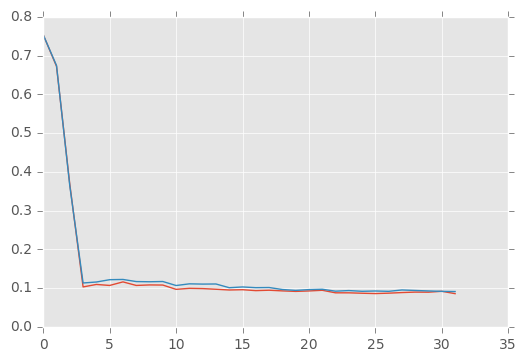

In [18]:
plt.plot(np.median(perf['loss'], axis=0))
plt.plot(np.mean(perf['loss'], axis=0))

(0.0, 10.0)

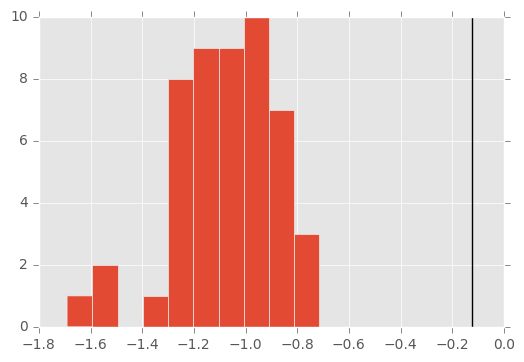

In [19]:
plt.hist(np.log10(perf['loss'][:, -1]))
ylim = plt.ylim()
plt.vlines(np.log10(perf['loss'][:, 0].mean()), *ylim)
plt.ylim(*ylim)

## Data Handling ##

In [20]:
data_store = h5py.File('./Fiducials.hdf5')
GS_2 = data_store['GS_2'].value

In [21]:
n_shots = 1000

In [22]:
counts = (GS_2 * n_shots).astype(int)

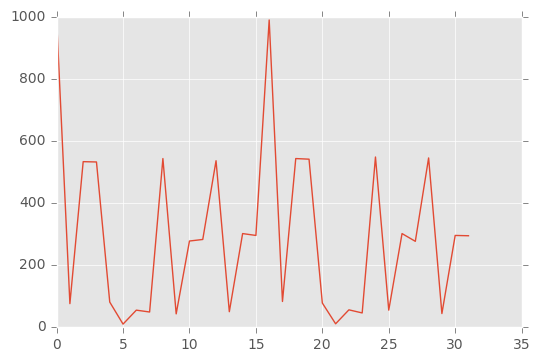

In [23]:
plt.plot(counts)

## Updater Loop ##

In [25]:
expparams['n_meas'] = 50
number_of_batches = 1

exp_data = np.round(
    GS_2[0:32] * expparams['n_meas'][0] * number_of_batches
)

print(exp_data)

[ 50.   4.  27.  27.   4.   0.   3.   2.  27.   2.  14.  14.  27.   2.  15.
  15.  50.   4.  27.  27.   4.   1.   3.   2.  27.   3.  15.  14.  27.   2.
  15.  15.]


In [26]:
ideal_data = np.zeros_like(GS_2)

for idx_batch in range(number_of_batches):
    for idx_experiment, experiment in enumerate(expparams[:, np.newaxis]):
        datum = model.simulate_experiment(true_mps, experiment)
        ideal_data[idx_experiment] += datum

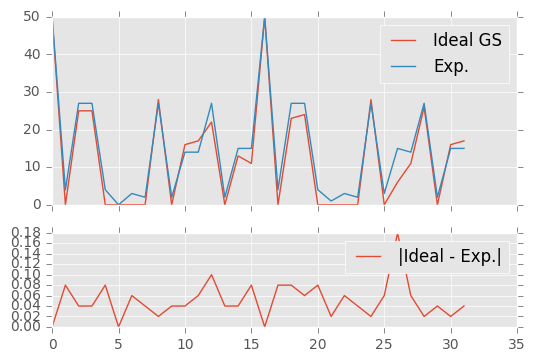

In [27]:
fig, (top, bottom) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

top.plot(ideal_data, label='Ideal GS')
top.plot(exp_data, label='Exp.')
top.legend()

bottom.plot(np.abs(ideal_data - exp_data) / 50, label='|Ideal - Exp.|')
bottom.legend()

In [28]:
updater = qi.SMCUpdater(model, 20000, prior, resample_thresh=0.1)

In [29]:
idxs_random = np.arange(len(exp_data))

for idx_batch in range(number_of_batches):
    np.random.shuffle(idxs_random)    
    for exp_datum, experiment in zip(
            exp_data[idxs_random], 
            expparams[idxs_random, np.newaxis]
        ):
        datum = np.round(exp_datum / number_of_batches)
        updater.update(datum, experiment)

In [30]:
prior_purities = [
    (basis.modelparams_to_state(particle) ** 2).tr()
    for particle in prior.sample(10000)
]
post_purities = [
    (basis.modelparams_to_state(particle) ** 2).tr()
    for particle in updater.sample(10000)
]

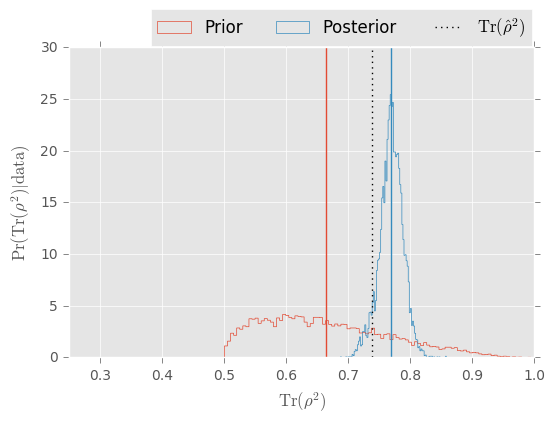

In [31]:
_, _, prior_hist = plt.hist(prior_purities, normed=True, bins=100, histtype='step', label='Prior')
_, _, post_hist = plt.hist(post_purities, normed=True, bins=100, histtype='step', label='Posterior')
plt.xlabel(r'$\operatorname{Tr}(\rho^2)$')
plt.ylabel(r'$\Pr(\operatorname{Tr}(\rho^2) | \mathrm{data})$')
plt.xlim(
    xmin=(qt.Qobj(np.diag([1] * 4)).unit() ** 2).tr(),
    xmax=1
)
# plt.xlim(0.68, 0.75)
ylim = plt.ylim()
plt.vlines(
    (basis.modelparams_to_state(updater.est_mean()) ** 2).tr(),
    *ylim,
    label=r'$\operatorname{Tr}(\hat{\rho}^2)$',
    linestyle=':'
)
plt.vlines(np.mean(prior_purities), *ylim, color=prior_hist[0].get_edgecolor())
plt.vlines(np.mean(post_purities), *ylim, color=post_hist[0].get_edgecolor())
plt.ylim(*ylim)
plt.legend(ncol=3, bbox_to_anchor=(1.0125, 1.15))

In [32]:
est_state = basis.modelparams_to_state(updater.est_mean())
est_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.83241672+0.j         -0.05782466-0.03432808j -0.10583329-0.0053699j
   0.03289311-0.01895406j]
 [-0.05782466+0.03432808j  0.05800898+0.j          0.00304346+0.01847818j
   0.01567468+0.00043948j]
 [-0.10583329+0.0053699j   0.00304346-0.01847818j  0.06818886+0.j
  -0.00328771-0.01297445j]
 [ 0.03289311+0.01895406j  0.01567468-0.00043948j -0.00328771+0.01297445j
   0.04138544+0.j        ]]

In [33]:
true_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

In [34]:
updater.est_mean()

array([  5.00000000e-01,  -6.11123694e-02,   4.73025302e-02,
         4.00605578e-01,  -9.01586142e-02,   3.59365753e-02,
         3.74322374e-02,  -1.21507975e-01,   4.93041462e-03,
         4.75874672e-04,  -2.98496537e-02,   5.80938400e-03,
         3.90425697e-01,  -5.45369582e-02,   2.13536321e-02,
         3.73802157e-01])

In [35]:
(true_mps - updater.est_mean())[0, :]

array([  3.38618023e-15,   6.11123694e-02,  -4.73025302e-02,
         9.93944220e-02,   9.01586142e-02,  -3.59365753e-02,
        -3.74322374e-02,   1.21507975e-01,  -4.93041462e-03,
        -4.75874672e-04,   2.98496537e-02,  -5.80938400e-03,
         1.09574303e-01,   5.45369582e-02,  -2.13536321e-02,
         1.26197843e-01])

From the above performance analysis, we expect this to be on the order of 0.1.

In [36]:
((true_mps - updater.est_mean()) ** 2).sum()

0.073748842802795644

C:\Users\cgran\Anaconda2\lib\site-packages\matplotlib\mathtext.py:865: MathTextWarning: Font 'rm' does not have a glyph for '\ud835' [Ud835]
  MathTextWarning)
C:\Users\cgran\Anaconda2\lib\site-packages\matplotlib\mathtext.py:866: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


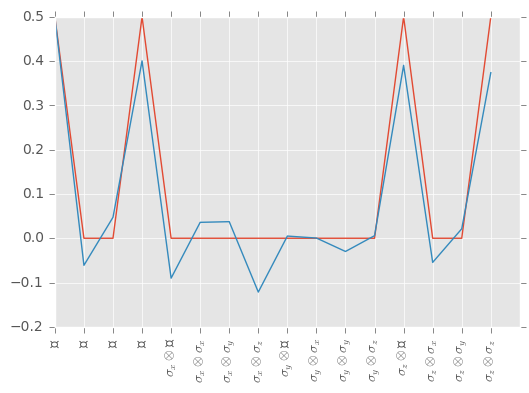

In [37]:
plt.plot(true_mps[0])
plt.plot(updater.est_mean())
plt.xticks(np.arange(16), map(u"${}$".format, basis.labels), rotation='vertical');

In [38]:
ideal_data = np.zeros_like(GS_2)
reconstructed_data = np.zeros_like(GS_2)
reconstructed_credible = np.zeros(GS_2.shape + (2,))

for idx_batch in range(number_of_batches):
    for idx_experiment, experiment in enumerate(expparams[:, np.newaxis]):
        ideal_data[idx_experiment] = model.simulate_experiment(true_mps, experiment)
        reconstructed_data[idx_experiment] = model.simulate_experiment(updater.est_mean()[None], experiment)
        reconstructed_credible[idx_experiment] = quantile_range(
            lower=0.025, upper=1 - 0.025
        )(
            model.simulate_experiment(updater.sample(1000), experiment)[0, :, 0],
            axis=0
        )

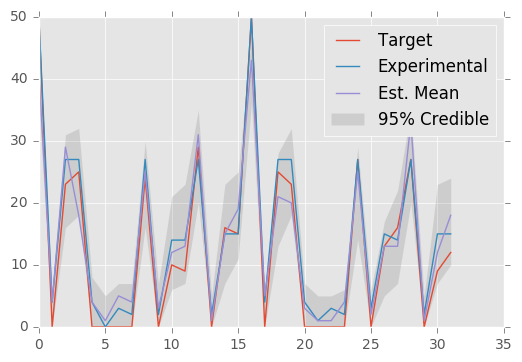

In [39]:
plt.plot(ideal_data, label='Target')
plt.plot(exp_data, label='Experimental')
plt.plot(reconstructed_data, label='Est. Mean')
plt.fill_between(
    x=np.arange(len(exp_data)),
    y1=reconstructed_credible[:, 0],
    y2=reconstructed_credible[:, 1],
    alpha=0.1,
    facecolor='k',
    label='95% Credible'
)
plt.legend()

# plt.figure()
# plt.plot(np.abs(ideal_data - exp_data))

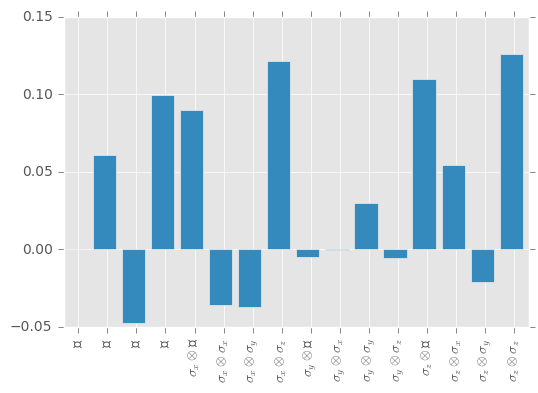

In [40]:
plt.bar(np.arange(16), (true_mps - updater.est_mean())[0, :])
plt.xticks(np.arange(16) + 0.5, map(u"${}$".format, basis.labels), rotation='vertical');

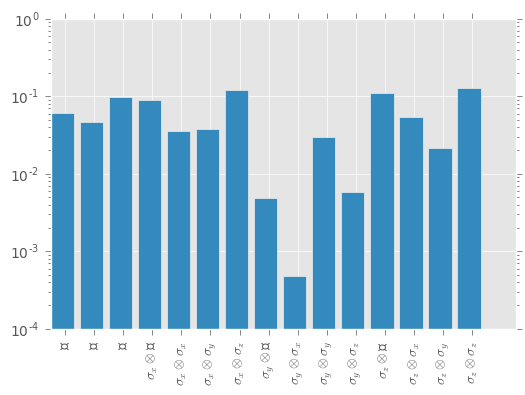

In [41]:
plt.bar(np.arange(15), np.abs(true_mps - updater.est_mean())[0, 1:])
plt.xticks(np.arange(15) + 0.5, map(u"${}$".format, basis.labels[1:]), rotation='vertical');
plt.gca().set_yscale('log')

NB: we omit the traceful part (modelparam 0) when taking the hull. The convex hull algorithm (quickhull) is fast in the number of points, but very slow in the number of dimensions, so this call will take a long time.

In [42]:
# faces, vertices = updater.region_est_hull(modelparam_slice=np.s_[1:])